In [151]:
using CancerSeqSim, Distributions, Gadfly

In [152]:
type cancercell
    mutations::Array{Int64,1}
    fitness::Int64
end

In [185]:
function newmutations(cancercell, mutID, p)

    numbermutations= 1
    cancercell.mutations = append!(cancercell.mutations, mutID:mutID+numbermutations-1)
    mutID = mutID + numbermutations
    
    neoep = rand()<p
    if neoep
        cancercell.fitness = 0
    end

    return cancercell, mutID, neoep
end

function copycell(cancercellold::cancercell)
  newcancercell::cancercell = cancercell(copy(cancercellold.mutations), copy(cancercellold.fitness))
end

function tumourgrow_birthdeath_neoep(b0, d0, b_, d_, Nmax, p)


    #Rmax starts with b + d and changes once a fitter mutant is introduced, this ensures that
    # b and d have correct units
    Rmax = b0+d_

    #initialize arrays and parameters
    mutID = 1
    cells = cancercell[]
    push!(cells,cancercell([],1))
    cells[1],mutID,neoep = newmutations(cells[1],mutID, p)
    cells[1].fitness = 1 #manually overwrite
    muts = Int64[]
    neoep_muts = Int64[]
    push!(muts,mutID)
    N = 1
    Nvec = Int64[]
    push!(Nvec,N)
    t = 0.0
    tvec = Float64[]
    push!(tvec,t)

    while N < Nmax

        #pick a random cell
        randcell = rand(1:N)
        r = rand(Uniform(0,Rmax))
        Nt = N
        
        if cells[randcell].fitness==0 #set death rate according to whether cell is antigenic or not
            d = d_
        else
            d = d0
        end

        #birth event if r<birthrate, access correct birthrate from cells array
        if r < b0

            #population increases by one
            N = N + 1
            #copy cell and mutations for cell that reproduces
            push!(cells, copycell(cells[randcell]))
            #add new mutations to both new cells
            cells[randcell],mutID,neoep = newmutations(cells[randcell],mutID, p)
            push!(muts,mutID)
            if neoep
                push!(neoep_muts, mutID)
            end
            cells[end],mutID,neoep = newmutations(cells[end],mutID, p)
            push!(muts,mutID)
            if neoep
                push!(neoep_muts, mutID)
            end
            
            push!(Nvec, N)
            Δt =  1/(Rmax * Nt) .* - log(rand())
            t = t + Δt
            push!(tvec,t)
            
        end

        if  (b0+d)<= r
          push!(Nvec, N)
          Δt =  1/(Rmax * Nt) .* - log(rand())
          t = t + Δt
          push!(tvec,t)
        end

        #death event if b<r<b+d
        if b0 <= r < (b0+d)

            #population decreases by 1
            N = N - 1
            #frequency of cell type decreases
            #remove deleted cell
            deleteat!(cells,randcell)
            push!(Nvec,N)
            Δt =  1/(Rmax * Nt) .* - log(rand())
            t = t + Δt
            push!(tvec,t)
        end

        #every cell dies reinitialize simulation
        if (N == 0)
                mutID = 1
        cells = cancercell[]
    push!(cells,cancercell([],1))
    cells[1],mutID,neoep = newmutations(cells[1],mutID, p)
    cells[1].fitness = 1 #manually overwrite
    muts = Int64[]
    neoep_muts = Int64[]
    push!(muts,mutID)
    N = 1
    Nvec = Int64[]
    push!(Nvec,N)
    t = 0.0
    tvec = Float64[]
    push!(tvec,t)
        end

    end
    
    return Nvec, tvec, muts, neoep_muts, cells
end

function analyse_mutations(cells, muts, neoep_muts, detLim=0)
    push!(muts, 1)
    fitnessVec = []
    mutVec = []
    for i=1:length(cells)
        push!(fitnessVec, cells[i].fitness)
        append!(mutVec, cells[i].mutations)
    end
    
    detmuts = []
    detneoep_muts = []
for mutID in muts
    if sum(mutVec.==mutID) > detLim
        push!(detmuts, mutID)
        if mutID in neoep_muts
            push!(detneoep_muts, mutID)
        end
    end
end
    
    mutRatio = length(detneoep_muts)/length(detmuts)
    
    return mutRatio, fitnessVec
end
    

analyse_mutations (generic function with 2 methods)

In [207]:
mutRVec = []
fitRVec = []
for i=1:50
    p = randn()*0.04+0.826
    #p=0.8
    Nvec, tvec, muts, neoep_muts, cells = tumourgrow_birthdeath_neoep(1, 0.5, 1, 0.5, 1000, p);
    append!(growthpl.layers, layer(x=tvec, y=Nvec, Geom.step))
    mutRatio, fitnessVec = analyse_mutations(cells, muts, neoep_muts)
    push!(mutRVec, mutRatio)
    push!(fitRVec, sum(fitnessVec)/1000)
end

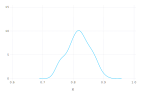

In [212]:
Gadfly.plot(x=mutRVec, Geom.density)

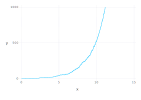

In [186]:
growthpl = Gadfly.plot(x=tvec, y=Nvec, Geom.step)

In [201]:
mutRVec_pfixed_homogenneg = mutRVec

50-element Array{Any,1}:
 0.805458
 0.786962
 0.801562
 0.796866
 0.800053
 0.79937 
 0.802525
 0.79984 
 0.792038
 0.798947
 0.804771
 0.809971
 0.797939
 ⋮       
 0.798975
 0.796412
 0.810227
 0.804583
 0.79648 
 0.812289
 0.787119
 0.795467
 0.799325
 0.796672
 0.806318
 0.791492

In [211]:
writedlm("mutVec_pnormal_neutral", mutRVec)

Input parameters: 
	 Mutation rate: 10.00
	 Death rate of host population: 0.00
	 Effective mutation rate (μ/β): 10.00
	 Number of clonal mutation: 200
	 Number of subclones: 1

Subclone 1 
	Frequency: 0.55
	Number of mutations in subclone: 121
	Fitness advantage: 8.20
	Time subclone emerges (population doublings): 7.92
	Number of divisions: 13
	Average number of divisions per cell: 11.08
	Population size when subclone emerges: 242
	Parent of subclone (0 is host): 0


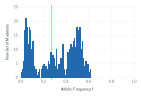

In [8]:
simdata = simulate(0.4, 0.6, μ = 10.0, clonalmutations = 200)
#print summary
show(simdata)

#plot histogram
vafhistogram(simdata, annotateclones = true)

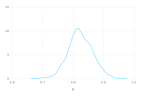

In [184]:
Gadfly.plot(x=randn((1000,1))*0.04+0.826, Geom.density)

search: randn randn! sprandn randstring ZeroMeanDiagNormal



```
randn([rng=GLOBAL_RNG], [T=Float64], [dims...])
```

Generate a normally-distributed random number of type `T` with mean 0 and standard deviation 1. Optionally generate an array of normally-distributed random numbers. The `Base` module currently provides an implementation for the types [`Float16`](@ref), [`Float32`](@ref), and [`Float64`](@ref) (the default).

# Examples

```jldoctest
julia> rng = MersenneTwister(1234);

julia> randn(rng, Float64)
0.8673472019512456

julia> randn(rng, Float32, (2, 4))
2×4 Array{Float32,2}:
 -0.901744  -0.902914  2.21188   -0.271735
 -0.494479   0.864401  0.532813   0.502334
```
